# Urban Nightscapes: An analysis of San Antonio, Texas using ISS photographs

In [398]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
import numpy as np
import numpy.ma as ma
import numpy.random
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from pprint import pprint as pp

### Read files, print some metadata

In [399]:
# Read image data using rasterio
impervious_data = "data/impervious.tif"
# ntl_data = "data/ntl770.img"
# ntl_data = "data/ntl795.img"
# ntl_data = "data/ntl632.img"
# ntl_data = "data/632step3d.tif"
ntl_data = "data/rescaled/rescaled795.img"

impervious = rasterio.open(impervious_data)
ntl = rasterio.open(ntl_data)

print(f"The number of bands in {impervious.name} is {impervious.count}.")
print(f"The width (or number of columns) of the image is: {impervious.width}.")
print(f"The height (or number of rows) the image is {impervious.height}.")
print(f"The datatype is {impervious.dtypes}")
print(impervious.shape)
print(impervious.bounds)
print(f"The upper-left coordinate is {impervious.transform * (0, 0)}.")
print(f"\tThe min and max values are: {np.min(impervious.read(1))} and {np.max(impervious.read(1))}  *ArcGIS codes 'null' values as large positive numbers??")

print()

print(f"The number of bands in {ntl.name} is {ntl.count}.")
print(f"The width (or number of columns) of the image is: {ntl.width}.")
print(f"The height (or number of rows) the image is {ntl.height}.")
print(f"The datatype is {ntl.dtypes}")
print(ntl.shape)
print(ntl.bounds)
print(f"The upper-left coordinate is {ntl.transform * (0, 0)}.")
print(f"\tThe min and max values are: {np.min(ntl.read(1))} and {np.max(ntl.read(1))} *ERDAS codes 'null' values as large negative numbers??")

The number of bands in data/impervious.tif is 1.
The width (or number of columns) of the image is: 1447.
The height (or number of rows) the image is 1350.
The datatype is ('uint32',)
(1350, 1447)
BoundingBox(left=2060800.9440954728, bottom=13634561.991441127, right=2203175.170243818, top=13767392.126410212)
The upper-left coordinate is (2060800.9440954728, 13767392.126410212).
	The min and max values are: 0 and 4294967295  *ArcGIS codes 'null' values as large positive numbers??

The number of bands in data/rescaled/rescaled770.img is 1.
The width (or number of columns) of the image is: 1447.
The height (or number of rows) the image is 1350.
The datatype is ('float32',)
(1350, 1447)
BoundingBox(left=2060800.9440954728, bottom=13634561.991441127, right=2203175.170243818, top=13767392.126410212)
The upper-left coordinate is (2060800.9440954728, 13767392.126410212).
	The min and max values are: -3.4028234663852886e+38 and 255.0 *ERDAS codes 'null' values as large negative numbers??


### Display images (using rasterio)

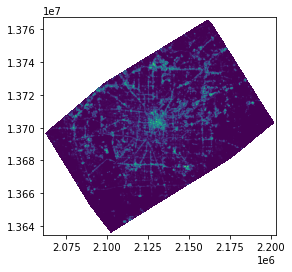

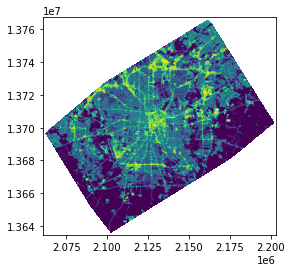

<AxesSubplot:>

In [400]:
show(ntl)
show(impervious)

### Dispaly histograms (using rasterio)

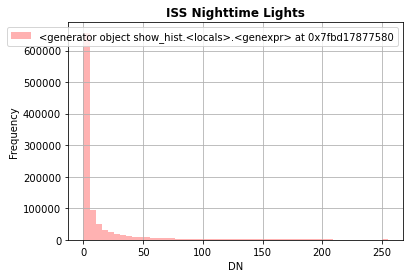

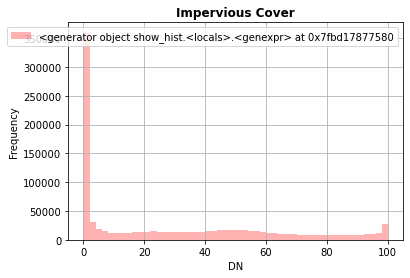

In [401]:
show_hist(ntl, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="ISS Nighttime Lights")
show_hist(impervious, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Impervious Cover")

### Mask the nighttime lights data (x) and print some metadata

In [402]:
x = ntl.read(1).flatten().astype('float32')
y = impervious.read(1).flatten().astype('float32')
print(f"The original shape of 'x' is {x.shape}", end=" <--> ")
print(f"The original shape of 'y' is {y.shape}")

# Depending on the system where the original data (images) were created
# NoData values may be code as very small (i.e., negative) numbers...or...
# as very large negative numbers. So even though the actual range of
# impervious cover should be [0..255], there will be a large or a small value
# representing NoData values. 500 is larger than the expected largest value,
# but less than the possible NoData value. (500 could also have been 255.)
x = ma.masked_where(x <= 0, x)
x = ma.masked_where(x > 500, x)
y = ma.masked_where(y < 0, y)
y = ma.masked_where(y > 500, y)

y = ma.masked_where(x.mask==True, y)

# x = x[x.mask == False]
x = ma.compressed(x)
# y = y[y.mask == False]
y = ma.compressed(y)

print(f"The masked shape of 'x' is {x.shape}", end=" <--> ")
print(f"The masked shape of 'y' data is {y.shape}")
print()
print(f"The min/max values for 'x' (nighttime lights) are {x.min()} and {x.max()}, respectively.")
print(x)
print()
print(f"The min/max values for 'y' (impervious cover) are {y.min()} and {y.max()}, respectively.")
print(y)

The original shape of 'x' is (1953450,) <--> The original shape of 'y' is (1953450,)
The masked shape of 'x' is (691506,) <--> The masked shape of 'y' data is (691506,)

The min/max values for 'x' (nighttime lights) are 0.041020408272743225 and 255.0, respectively.
[0.17142858 0.27061224 0.527551   ... 0.4632653  0.36081633 0.12428571]

The min/max values for 'y' (impervious cover) are 0.0 and 100.0, respectively.
[ 0.  1. 25. ...  0.  0.  0.]


### Mask the impervious data (y) and print some metadata

In [403]:
# y = impervious.read(1).flatten().astype('float32')
# print(f"The original shape of 'y' is {y.shape}")
# # Depending on the system where the original data (images) were created
# # NoData values may be code as very small (i.e., negative) numbers...or...
# # as very large negative numbers. So even though the actual range of
# # impervious cover should be [0, 100], there will be a large or a small value
# # representing NoData values. 500 is larger than the expected largest value,
# # but less than the possible NoData value.  (500 could also have been 100.)
# y = ma.masked_where(y < 0, y)
# y = ma.masked_where(y > 500, y)

# # y = y[y.mask == False]
# y = ma.compressed(y)
# print(f"The masked shape of 'y' data is {y.shape}")
# print()
# print(f"The min/max values for 'y'  are {y.min()} and {y.max()}, respectively.")
# print(y)

### Mask the nighttime lights data (x) and print some metadata

In [404]:
# x = ntl.read(1).flatten().astype('float32')
# # Depending on the system where the original data (images) were created
# # NoData values may be code as very small (i.e., negative) numbers...or...
# # as very large negative numbers. So even though the actual range of
# # impervious cover should be [0..255], there will be a large or a small value
# # representing NoData values. 500 is larger than the expected largest value,
# # but less than the possible NoData value. (500 could also have been 255.)
# x = ma.masked_where(x < 0, x)
# x = ma.masked_where(x > 500, x)
# print(f"The original shape of 'x' is {x.shape}")
# # x = x[x.mask == False]
# x = ma.compressed(x)
# print(f"The masked shape of 'x' is {x.shape}")
# print()
# print(f"The min/max values for 'x' (nighttime lights) are {x.min()} and {x.max()}, respectively.")
# print(x)

### Create logx as log(x) and print some metadata

In [405]:
logx = np.log(x)
print(f"The masked shape of 'logx' is {logx.shape}")
print()
print(f"The min/max values for 'logx' (nighttime lights) are {logx.min()} and {logx.max()}, respectively.")
print(x)

The masked shape of 'logx' is (691506,)

The min/max values for 'logx' (nighttime lights) are -3.193685531616211 and 5.541263580322266, respectively.
[0.17142858 0.27061224 0.527551   ... 0.4632653  0.36081633 0.12428571]


### Plot histograms of x, logx, and y (using matplotlib)

(array([118361.,  24978.,  17871.,  15022.,  15681.,  17313.,  12304.,
         19040.,  19236.,  19086.,  18955.,  18714.,  18819.,  12863.,
         20903.,  23005.,  23887.,  23940.,  22795.,  20553.,  12605.,
         16824.,  15049.,  13321.,  12756.,  12245.,  11771.,   7511.,
         11297.,  11732.,  12298.,  13138.,  14306.,  16868.,  26459.]),
 array([  0.      ,   2.857143,   5.714286,   8.571428,  11.428572,
         14.285714,  17.142857,  20.      ,  22.857143,  25.714285,
         28.571428,  31.428572,  34.285713,  37.142857,  40.      ,
         42.857143,  45.714287,  48.57143 ,  51.42857 ,  54.285713,
         57.142857,  60.      ,  62.857143,  65.71429 ,  68.57143 ,
         71.42857 ,  74.28571 ,  77.14286 ,  80.      ,  82.85714 ,
         85.71429 ,  88.57143 ,  91.42857 ,  94.28571 ,  97.14286 ,
        100.      ], dtype=float32),
 <BarContainer object of 35 artists>)

<Figure size 432x288 with 0 Axes>

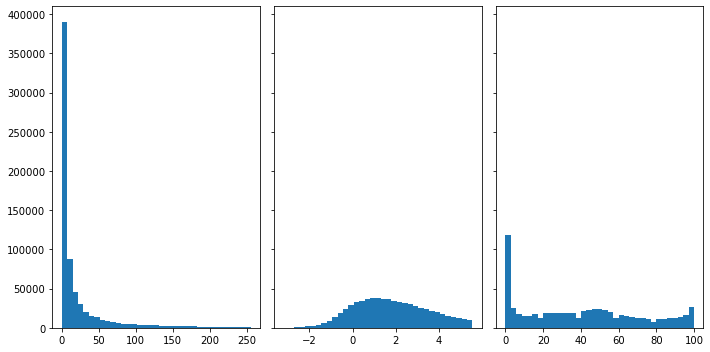

In [406]:
bins = 35
plt.clf()
# plt.figure(figsize=(10, 10))
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(10, 5))

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x, bins=bins)
axs[1].hist(logx, bins=bins)
axs[2].hist(y, bins=bins)

### Plot heatmaps

<ipython-input-407-4b7abb438c37>:17: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  c0 = axs[0].imshow(heatmap.T, cmap='summer', norm=mpl.colors.SymLogNorm(2), extent=extent, origin='lower', aspect='auto')
<ipython-input-407-4b7abb438c37>:18: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  c1 = axs[1].imshow(log_heatmap.T, cmap='summer', norm=mpl.colors.SymLogNorm(2), extent=log_extent, origin='lower', aspect='auto')


<Figure size 432x288 with 0 Axes>

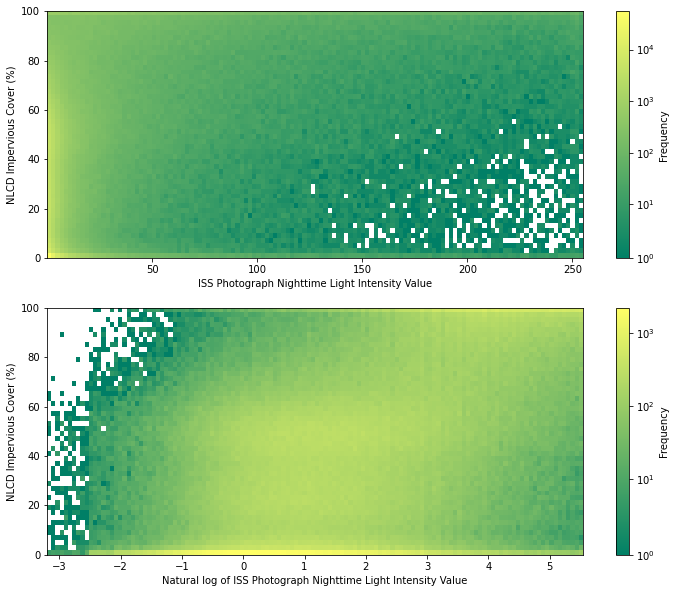

In [407]:
# Original NTL heatmap
heatmap, xedges, yedges = np.histogram2d(x, y, bins=(128, 50))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
heatmap[heatmap == 0] = np.NaN

# Log transformed NTL heatmap
log_heatmap, log_xedges, log_yedges = np.histogram2d(logx, y, bins=(128, 50))
log_extent = [log_xedges[0], log_xedges[-1], log_yedges[0], log_yedges[-1]]
log_heatmap[log_heatmap == 0] = np.NaN

# Setup sub-plots
plt.clf()
fig, axs = plt.subplots(2, 1, sharey=True, figsize=(12, 10))
fig.subplots_adjust(hspace=0.2)

# Plot heatmaps
c0 = axs[0].imshow(heatmap.T, cmap='summer', norm=mpl.colors.SymLogNorm(2), extent=extent, origin='lower', aspect='auto')
c1 = axs[1].imshow(log_heatmap.T, cmap='summer', norm=mpl.colors.SymLogNorm(2), extent=log_extent, origin='lower', aspect='auto')

# Add plot labels
axs[0].set_ylim([0, 100])
axs[0].set_xlabel("ISS Photograph Nighttime Light Intensity Value")
axs[0].set_ylabel("NLCD Impervious Cover (%)")
cbar0 = fig.colorbar(c0, ax=axs[0], ticks=[1, 10, 100, 1000, 10000, 100000])
cbar0.ax.set_ylabel('Frequency')

axs[1].set_ylim([0, 100])
axs[1].set_xlabel("Natural log of ISS Photograph Nighttime Light Intensity Value")
axs[1].set_ylabel("NLCD Impervious Cover (%)")
cbar1 = fig.colorbar(c1, ax=axs[1], ticks=[1, 10, 100, 1000, 10000])
cbar1.ax.set_ylabel('Frequency')

plt.show()

## OLS Regression

In [408]:
# Set 'regress_through_origin' to True if regression through origin is desired
regress_through_origin = True
if regress_through_origin:
    X = x
else:
    X = sm.add_constant(x, prepend=False)

ols_mod = sm.OLS(y, X)
ols_results = ols_mod.fit()
print(ols_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.359
Model:                            OLS   Adj. R-squared (uncentered):              0.359
Method:                 Least Squares   F-statistic:                          3.866e+05
Date:                Fri, 19 Mar 2021   Prob (F-statistic):                        0.00
Time:                        19:51:09   Log-Likelihood:                     -3.5496e+06
No. Observations:              691506   AIC:                                  7.099e+06
Df Residuals:                  691505   BIC:                                  7.099e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## OLS Regression with log(ISS)

In [409]:
# Set 'regress_through_origin' to True if regression through origin is desired
regress_through_origin = True
if regress_through_origin:
    logX = logx
else:
    logX = sm.add_constant(logx, prepend=False)

log_mod = sm.OLS(y, logX)
log_results = log_mod.fit()
print(log_results.params)
print(log_results.summary())

[16.36519]
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.621
Model:                            OLS   Adj. R-squared (uncentered):              0.621
Method:                 Least Squares   F-statistic:                          1.134e+06
Date:                Fri, 19 Mar 2021   Prob (F-statistic):                        0.00
Time:                        19:51:09   Log-Likelihood:                     -3.3675e+06
No. Observations:              691506   AIC:                                  6.735e+06
Df Residuals:                  691505   BIC:                                  6.735e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

## Polynomial Regression

### ...with original NTL data (i.e., not log transformed)

In [410]:
# polynomial fit
degree = 6

poly_weights = np.polyfit(x, y, degree)
print(f"The weight coefficient are: {poly_weights}\n")
poly_mod = np.poly1d(poly_weights)
print(f"The full polynomial equation is: \n{poly_mod}.\n")
df = pd.DataFrame(columns=['y', 'x'])
df['x'] = x
df['y'] = y
poly_results = smf.ols(formula='y ~ poly_mod(x)', data=df).fit()
print(poly_results.summary())
# end polynomial fit

/home/nate/anaconda3/envs/bradj_nightscapes/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3427: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


The weight coefficient are: [-2.19480616e-13 -3.95852496e-11 -4.90446793e-09  4.16369425e-07
  6.43527735e-04  3.21121435e-01  3.33151284e+01]

The full polynomial equation is: 
            6             5             4             3             2
-2.195e-13 x - 3.959e-11 x - 4.904e-09 x + 4.164e-07 x + 0.0006435 x + 0.3211 x + 33.32.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                 1.577e+05
Date:                Fri, 19 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:51:10   Log-Likelihood:            -3.2913e+06
No. Observations:              691506   AIC:                         6.583e+06
Df Residuals:                  691504   BIC:                         6.583e+06
Df Model:                     

### ...with log transformed NTL data

In [411]:
# polynomial fit
degree = 6

poly_log_weights = np.polyfit(logx, y, degree)
print(f"The weight coefficient are: {poly_log_weights}\n")
poly_log_mod = np.poly1d(poly_log_weights)
print(f"The full polynomial equation is: \n{poly_log_mod}.\n")
df = pd.DataFrame(columns=['y', 'x'])
df['x'] = logx
df['y'] = y
poly_log_results = smf.ols(formula='y ~ poly_log_mod(x)', data=df).fit()
print(poly_log_results.summary())
# end polynomial fit

/home/nate/anaconda3/envs/bradj_nightscapes/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3427: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


The weight coefficient are: [-5.59506238e-04 -1.37050021e-03  3.75537844e-03  8.65860694e-02
  8.88959623e-01  5.65800809e+00  2.42321173e+01]

The full polynomial equation is: 
            6            5            4           3         2
-0.0005595 x - 0.001371 x + 0.003755 x + 0.08659 x + 0.889 x + 5.658 x + 24.23.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                 2.508e+05
Date:                Fri, 19 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:51:10   Log-Likelihood:            -3.2553e+06
No. Observations:              691506   AIC:                         6.511e+06
Df Residuals:                  691504   BIC:                         6.511e+06
Df Model:                           1          

## Feature Space Image generation

### Plot feature space image with regression lines

<ipython-input-412-c9e0f4c4c241>:17: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  c0 = axs[0].imshow(heatmap.T, cmap='summer', norm=mpl.colors.SymLogNorm(2), extent=extent, origin='lower', aspect='auto')
<ipython-input-412-c9e0f4c4c241>:18: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  c1 = axs[1].imshow(log_heatmap.T, cmap='summer', norm=mpl.colors.SymLogNorm(2), extent=log_extent, origin='lower', aspect='auto')


<Figure size 432x288 with 0 Axes>

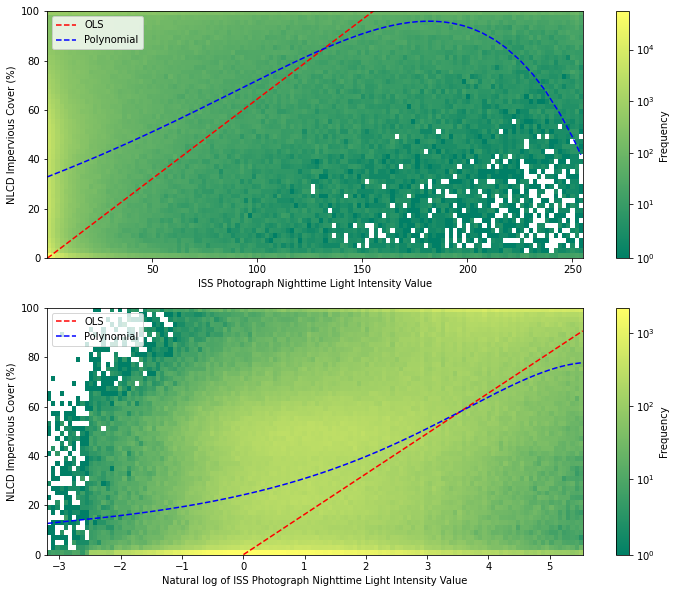

In [412]:
# Original NTL heatmap
heatmap, xedges, yedges = np.histogram2d(x, y, bins=(128, 50))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
heatmap[heatmap == 0] = np.NaN

# Log transformed NTL heatmap
log_heatmap, log_xedges, log_yedges = np.histogram2d(logx, y, bins=(128, 50))
log_extent = [log_xedges[0], log_xedges[-1], log_yedges[0], log_yedges[-1]]
log_heatmap[log_heatmap == 0] = np.NaN

# Setup sub-plots
plt.clf()
fig, axs = plt.subplots(2, 1, sharey=True, figsize=(12, 10))
fig.subplots_adjust(hspace=0.2)

# Plot heatmaps
c0 = axs[0].imshow(heatmap.T, cmap='summer', norm=mpl.colors.SymLogNorm(2), extent=extent, origin='lower', aspect='auto')
c1 = axs[1].imshow(log_heatmap.T, cmap='summer', norm=mpl.colors.SymLogNorm(2), extent=log_extent, origin='lower', aspect='auto')

# Add plot labels for heatmaps
axs[0].set_ylim([0, 100])
axs[0].set_xlabel("ISS Photograph Nighttime Light Intensity Value")
axs[0].set_ylabel("NLCD Impervious Cover (%)")
cbar0 = fig.colorbar(c0, ax=axs[0], ticks=[1, 10, 100, 1000, 10000, 100000])
cbar0.ax.set_ylabel('Frequency')

axs[1].set_ylim([0, 100])
axs[1].set_xlabel("Natural log of ISS Photograph Nighttime Light Intensity Value")
axs[1].set_ylabel("NLCD Impervious Cover (%)")
cbar1 = fig.colorbar(c1, ax=axs[1], ticks=[1, 10, 100, 1000, 10000])
cbar1.ax.set_ylabel('Frequency')

# Plot regression lines
get_every_nth = 999

## Original x values; no transformation
    ### OLS
df_ols = pd.DataFrame(columns=['y', 'x'])
df_ols['x'] = x
df_ols['y'] = ols_results.fittedvalues
df_ols = df_ols.sort_values(by=['x']).reset_index(drop=True)
df_ols = df_ols[df_ols.index % get_every_nth == 0]
axs[0].plot(df_ols['x'], df_ols['y'], 'r--', label="OLS")

    ### Polynomial regression
df_poly = pd.DataFrame(columns=['y', 'x'])
df_poly['x'] = x
df_poly['y'] = poly_results.fittedvalues
df_poly = df_poly.sort_values(by=['x']).reset_index(drop=True)
df_poly = df_poly[df_poly.index % get_every_nth == 0]
axs[0].plot(df_poly['x'], df_poly['y'], 'b--', label="Polynomial")

axs[0].legend(loc='best')

## Log transformed x values
    ### OLS
df_log_ols = pd.DataFrame(columns=['y', 'x'])
df_log_ols['x'] = logx
df_log_ols['y'] = log_results.fittedvalues
df_log_ols = df_log_ols.sort_values(by=['x']).reset_index(drop=True)
df_log_ols = df_log_ols[df_log_ols.index % get_every_nth == 0]
axs[1].plot(df_log_ols['x'], df_log_ols['y'], 'r--', label="OLS")

    ### Polynomial regression
df_log_poly = pd.DataFrame(columns=['y', 'x'])
df_log_poly['x'] = logx
df_log_poly['y'] = poly_log_results.fittedvalues
df_log_poly = df_log_poly.sort_values(by=['x']).reset_index(drop=True)
df_log_poly = df_log_poly[df_log_poly.index % get_every_nth == 0]
axs[1].plot(df_log_poly['x'], df_log_poly['y'], 'b--', label="Polynomial")

axs[1].legend(loc='best')

plt.show()

<ipython-input-413-9e924eafe4dd>:12: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  c1 = axs.imshow(log_heatmap.T, cmap='summer', norm=mpl.colors.SymLogNorm(2), extent=log_extent, origin='lower', aspect='auto')


<Figure size 432x288 with 0 Axes>

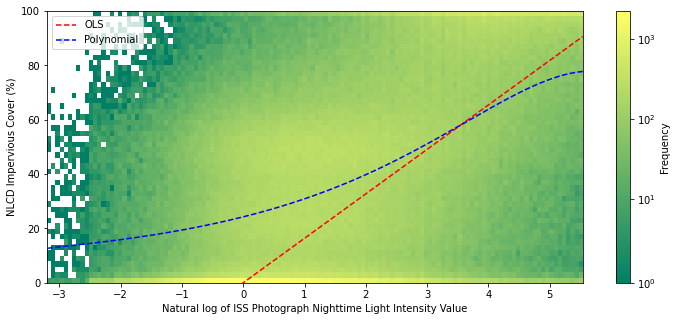

In [413]:
# Log transformed NTL heatmap
log_heatmap, log_xedges, log_yedges = np.histogram2d(logx, y, bins=(128, 50))
log_extent = [log_xedges[0], log_xedges[-1], log_yedges[0], log_yedges[-1]]
log_heatmap[log_heatmap == 0] = np.NaN

# Setup sub-plots
plt.clf()
fig, axs = plt.subplots(1, 1, sharey=True, figsize=(12, 5))
# fig.subplots_adjust(hspace=0.2)

# Plot heatmaps
c1 = axs.imshow(log_heatmap.T, cmap='summer', norm=mpl.colors.SymLogNorm(2), extent=log_extent, origin='lower', aspect='auto')

# Add plot labels for heatmaps
axs.set_ylim([0, 100])
axs.set_xlabel("Natural log of ISS Photograph Nighttime Light Intensity Value")
axs.set_ylabel("NLCD Impervious Cover (%)")
cbar1 = fig.colorbar(c1, ax=axs, ticks=[1, 10, 100, 1000, 10000, 100000])
cbar1.ax.set_ylabel('Frequency')

# Plot regression lines
get_every_nth = 999

## Log transformed x values
    ### OLS
df_log_ols = pd.DataFrame(columns=['y', 'x'])
df_log_ols['x'] = logx
df_log_ols['y'] = log_results.fittedvalues
df_log_ols = df_log_ols.sort_values(by=['x']).reset_index(drop=True)
df_log_ols = df_log_ols[df_log_ols.index % get_every_nth == 0]
axs.plot(df_log_ols['x'], df_log_ols['y'], 'r--', label="OLS")

    ### Polynomial regression
df_log_poly = pd.DataFrame(columns=['y', 'x'])
df_log_poly['x'] = logx
df_log_poly['y'] = poly_log_results.fittedvalues
df_log_poly = df_log_poly.sort_values(by=['x']).reset_index(drop=True)
df_log_poly = df_log_poly[df_log_poly.index % get_every_nth == 0]
axs.plot(df_log_poly['x'], df_log_poly['y'], 'b--', label="Polynomial")

axs.legend(loc='best')

plt.show()

### Done for now....

In [414]:
np.exp(0)

1.0

In [415]:
np.log(255)

5.541263545158426